In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Clase y función para crear la capa de z en base a z_mean y z_log_var utilizando el <b>reparametrization trick</b>
###  <b><a href="https://www.youtube.com/watch?v=TQ67J0laA-g">Fuente: Deep Learning Lecture 11.3 - Variational Autoencoder Implementation</a></b> 
![reparameterization](images/Reparametrization-trick.jpg)

In [18]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [19]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [20]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## En la función de entrenamiento no hay epsilon ni tf.keras.backend.random_normal, solo hay optimización de la función de loss, que ahora es determinística.

In [21]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [22]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
vae = VAE(encoder, decoder)

In [23]:
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=500, batch_size=128)

Epoch 1/500
547/547 [==============================] - 7s 11ms/step - loss: 262.6288 - reconstruction_loss: 216.3597 - kl_loss: 1.4628
Epoch 2/500
547/547 [==============================] - 6s 11ms/step - loss: 192.0133 - reconstruction_loss: 185.5461 - kl_loss: 3.7320
Epoch 3/500
547/547 [==============================] - 6s 11ms/step - loss: 174.5157 - reconstruction_loss: 166.1526 - kl_loss: 5.6447
Epoch 4/500
547/547 [==============================] - 6s 11ms/step - loss: 167.6035 - reconstruction_loss: 160.6664 - kl_loss: 5.9261
Epoch 5/500
547/547 [==============================] - 6s 11ms/step - loss: 164.4504 - reconstruction_loss: 157.7218 - kl_loss: 6.1405
Epoch 6/500
547/547 [==============================] - 6s 11ms/step - loss: 162.1435 - reconstruction_loss: 155.7388 - kl_loss: 6.1941
Epoch 7/500
547/547 [==============================] - 6s 12ms/step - loss: 160.9477 - reconstruction_loss: 154.2659 - kl_loss: 6.2230
Epoch 8/500
547/547 [==============================] - 

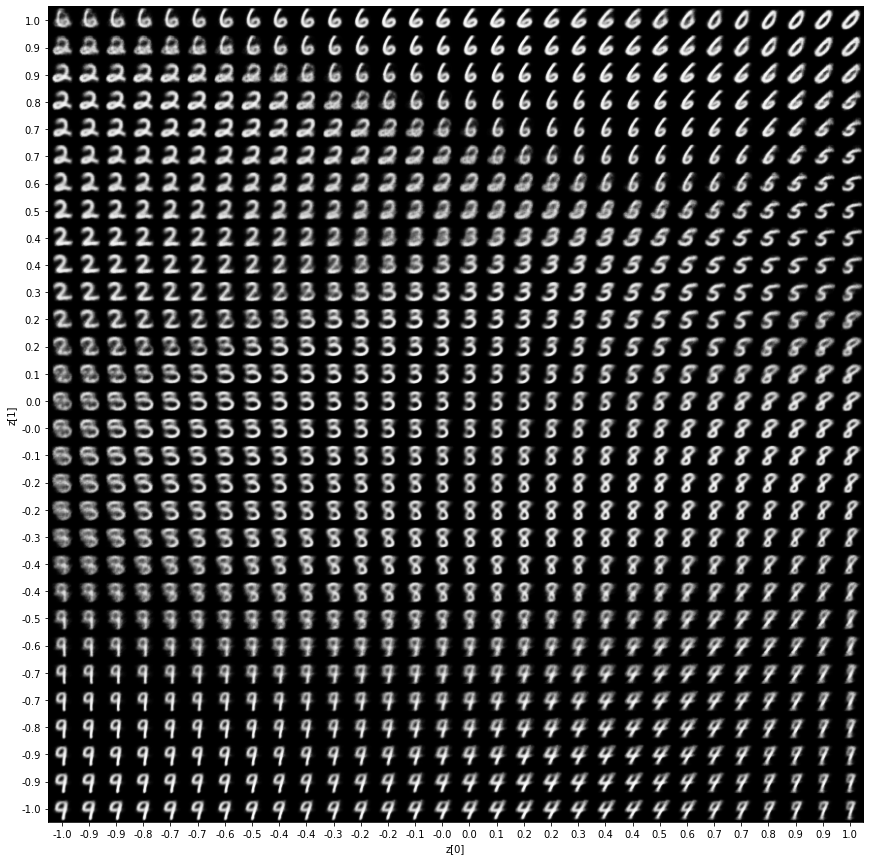

In [24]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

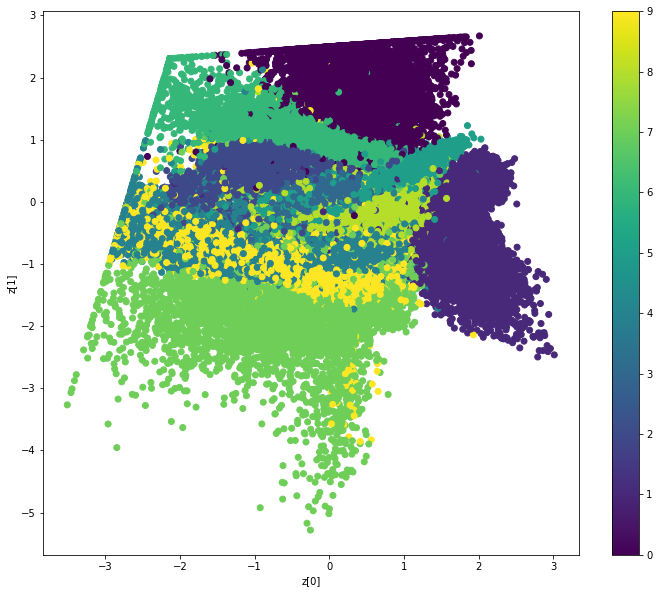

In [25]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# <font color='blue'>Tarea (Parte I)
## 1.	Tome el archivo “3-Variational AutoEncoder” visto y explicado en clase, aplique los cambios necesarios para que el entrenamiento del codificador y decodificador puedan ser salvados y almacenados, tal y como fue comentado en clase.</font>


# Salvo (.save()) por separado los modelos completos del encoder y decoder, no solo los weights por si eventualmente se necesitara algo más
### Se salvan: la arquitectura de los modelos, los pesos, la información de compilación, el optimizador con su estado

In [27]:
encoder.save("./SavedModels/encoder.SavedModel",overwrite=True,include_optimizer=True)
decoder.save("./SavedModels/decoder.SavedModel",overwrite=True,include_optimizer=True)

INFO:tensorflow:Assets written to: ./SavedModels/encoder.SavedModel\assets
INFO:tensorflow:Assets written to: ./SavedModels/decoder.SavedModel\assets


# <font color='blue'>Tarea (Parte II)
## 2.	Pruebe el código corriendo el algoritmo entrenado usando los codificadores y decodificadores entrenados que fueron salvados y almacenados, esto sin necesidad de tener que volverlos a entrenar, y que puedan realizar las salidas esperadas.</font>

### El backpropagation no puede pasar las gradientes (calcular derivadas) por el vector muestreado (proceso estocástico). Se utiliza un "Reparameterization trick" sacando el proceso de muestreo y poniéndolo de input del decoder, y se utiliza un epsilon para multiplicar sobre la desviación estándar, y se convierte en una función determinística, permitiendo un backpropagation.
### O sea, se vale tener Inputs estocásticos, pero no es posible que gradientes pasen por capas estocásticas, por eso hay que sacarlo.
###  <b>Fuente: Rowel Atienza - Advanced Deep Learning with TensorFlow 2 and Keras 2nd Edition (2020), p.260</b> 
![vae](images/vae.png) 

## El código que hice a continuación carga el encoder y decoder, uniéndolos por un muestreo de la distribución que creó el encoder (ya no se va a entrenar más). Por eso se toma únicamente el [2] de recovered_encoder(encoder_inputs)[2] como entrada del decoder.

# Cargo los modelos desde los archivos creados

In [28]:
recovered_encoder = keras.models.load_model("./SavedModels/encoder.SavedModel", compile=False)
recovered_decoder = keras.models.load_model("./SavedModels/decoder.SavedModel", compile=False)

# Ajusto las entradas y las salidas entre el encoder y el decoder

In [29]:
inputs = encoder_inputs
encoder_outputs = recovered_encoder(inputs)[2] #<----- Solamente el muestreo, sin el vector de medias y vector de log_vars
outputs = recovered_decoder(encoder_outputs)

# Analizo las arquitecturas resultantes de los modelos

In [30]:
recovered_vae = keras.models.Model(inputs, outputs, name="VAE")
recovered_encoder.summary()
recovered_decoder.summary()
recovered_vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

# Genero números pasándolos por el autoencoder variacional completo

In [31]:
xprime = recovered_vae.predict(mnist_digits)

# Ploteo las comparaciones entre 10 números originales y los 10 generados correspondientes

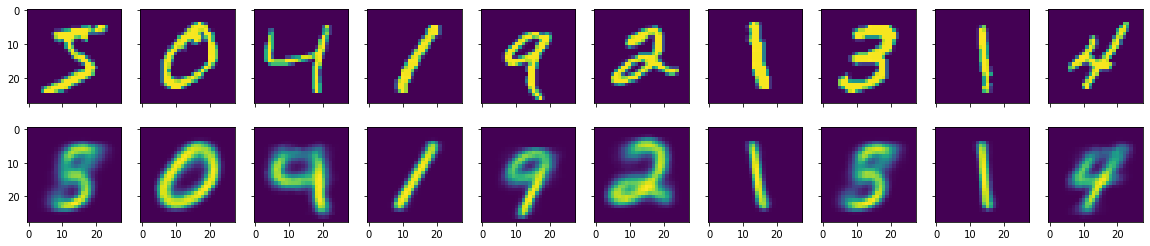

In [32]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
fig, ax = plt.subplots(2, 10, sharex='col', sharey='row')
for i in range(10):
        ax[0,i].imshow(mnist_digits[i]) #<---- Los originales
        ax[1,i].imshow(xprime[i]) #<---- Los generados por el autoencoder cargado

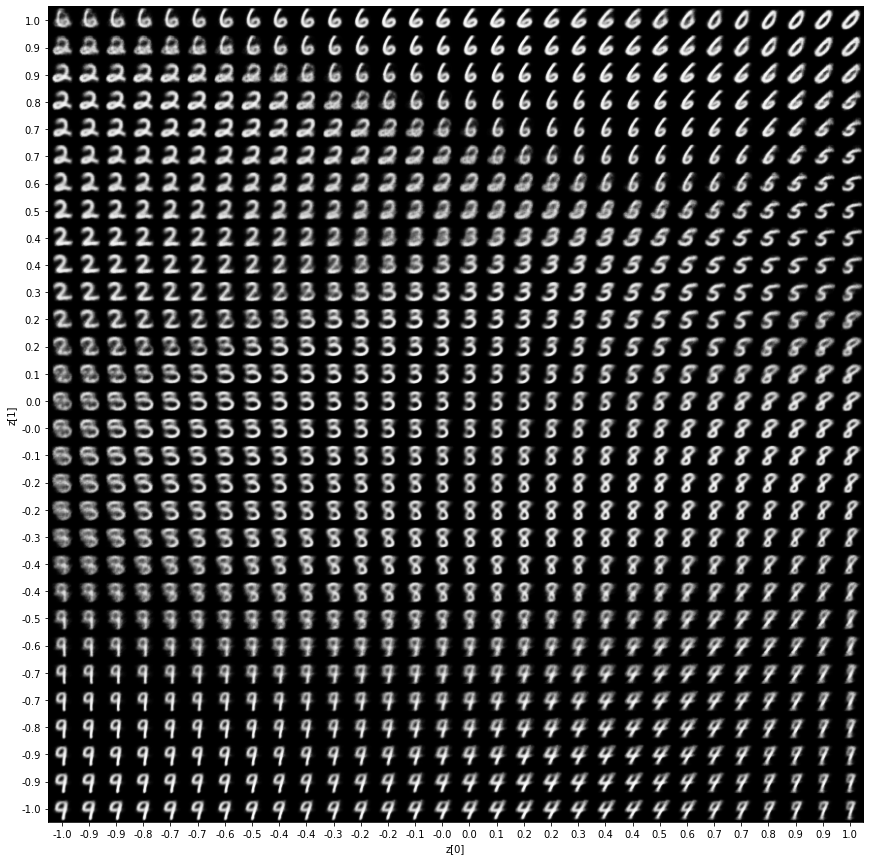

In [33]:
recovered_vae.decoder = recovered_decoder
plot_latent_space(recovered_vae)